In [1]:
library(tidyverse)
library(ggplot2)
library(factoextra)
library(reshape2)
library(umap)
library(ComplexHeatmap)
library(cluster)
library(dynamicTreeCut)
library(uwot)
library(RColorBrewer)
library(circlize)
library(svglite)
library(ggnewscale)

Warning message:
“Paket ‘tidyverse’ wurde unter R Version 4.1.2 erstellt”
── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 0.5.2
Warning message:
“Paket ‘ggplot2’ wurde unter R Version 4.1.2 erstellt”
Warning message:
“Paket ‘tibble’ wurde unter R Version 4.1.2 erstellt”
Warning message:
“Paket ‘tidyr’ wurde unter R Version 4.1.2 erstellt”
Warning message:
“Paket ‘readr’ wurde unter R Version 4.1.2 erstellt”
Warning message:
“Paket ‘purrr’ wurde unter R Version 4.1.2 erstellt”
Warning message:
“Paket ‘dplyr’ wurde unter R Version 4.1.2 erstellt”
Warning message:
“Paket ‘stringr’ wurde unter R Version 4.1.2 erstellt”
Warning message:
“Paket ‘forcats’ wurde unter R Version 4.1.2 erstellt”
── Conflicts ────────────────

In [2]:
load_dir <- "ARS316"

In [3]:
#Load a feature annotation with different annotation with fixed window sizes
methylation <- read.csv(paste(load_dir, "/ARS316_feature_methylation_window30_union_selected.csv", sep=""), 
                            stringsAsFactors=TRUE)
methylation <- methylation[, -1]

levels(methylation$condition) <- c("dies6", "disw2", "wt")
methylation$feature <- factor(methylation$feature, levels = c(seq(1:max(methylation$feature))))

In [4]:
levels(methylation$condition)

[1] "dies6" "disw2" "wt"

In [5]:
# test clustering only on positive or negative strand:
methylation %>% group_by(strand) %>% count() #for each strand, we have 97356 feature methylation values

methylation = methylation[methylation$strand == "plus", ]

strand,n
<fct>,<int>
minus,97356
plus,97356


In [6]:
methylation_long <- dcast(methylation, molecule + condition + replicate + strand ~feature, value.var = "norm_methylation")


In [7]:
scaled_meth <- scale(methylation_long[,-(1:4)])

In [8]:
pca_meth <- prcomp(scaled_meth)

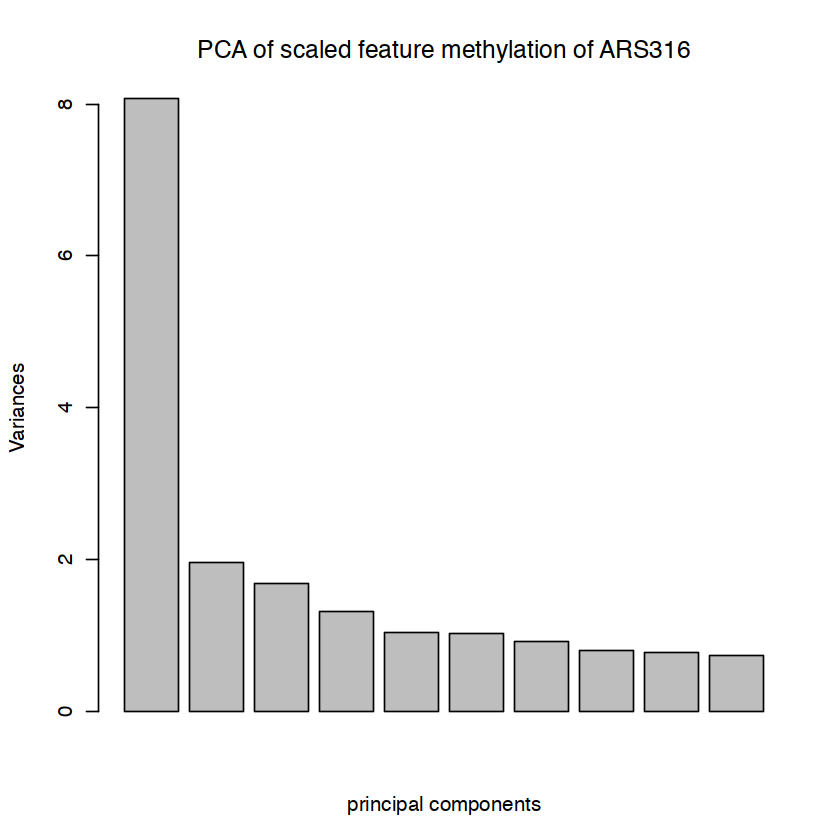

In [9]:
plot(pca_meth, main = "PCA of scaled feature methylation of ARS316", xlab = "principal components")

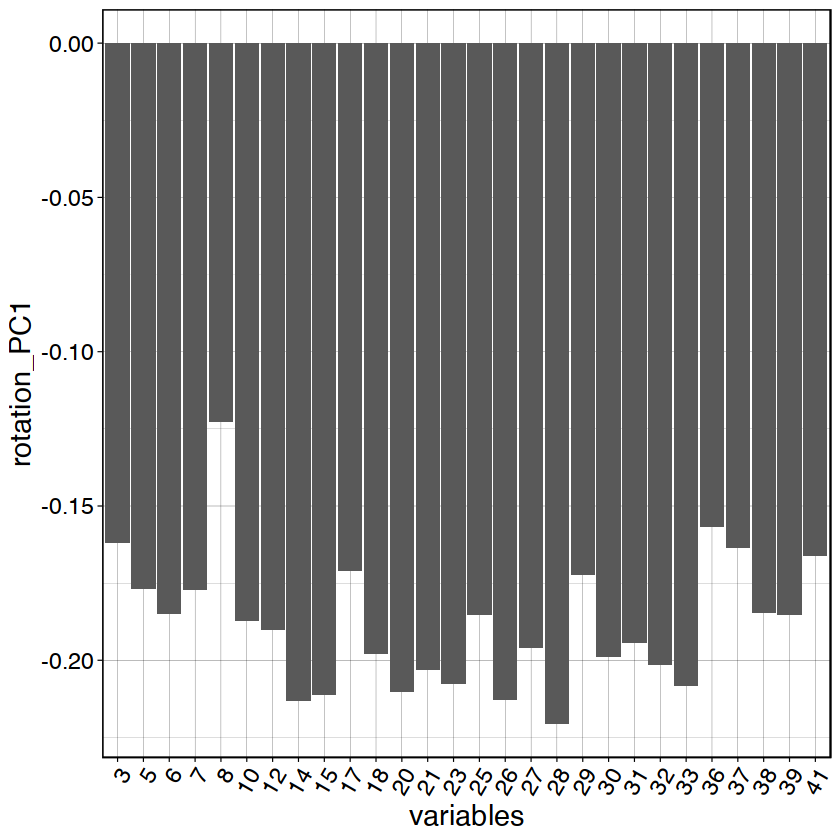

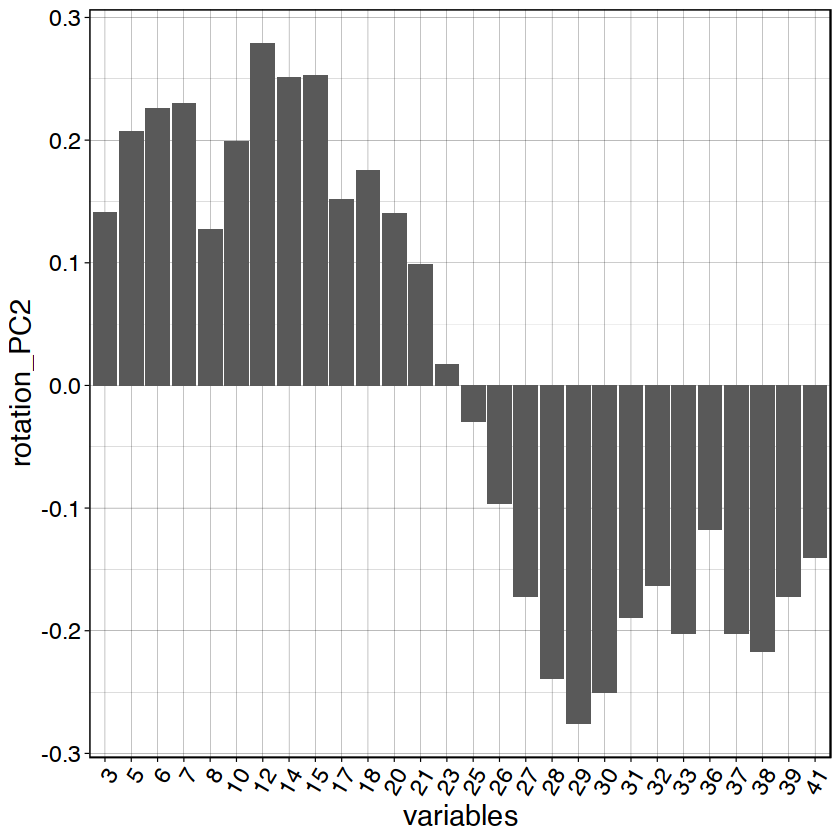

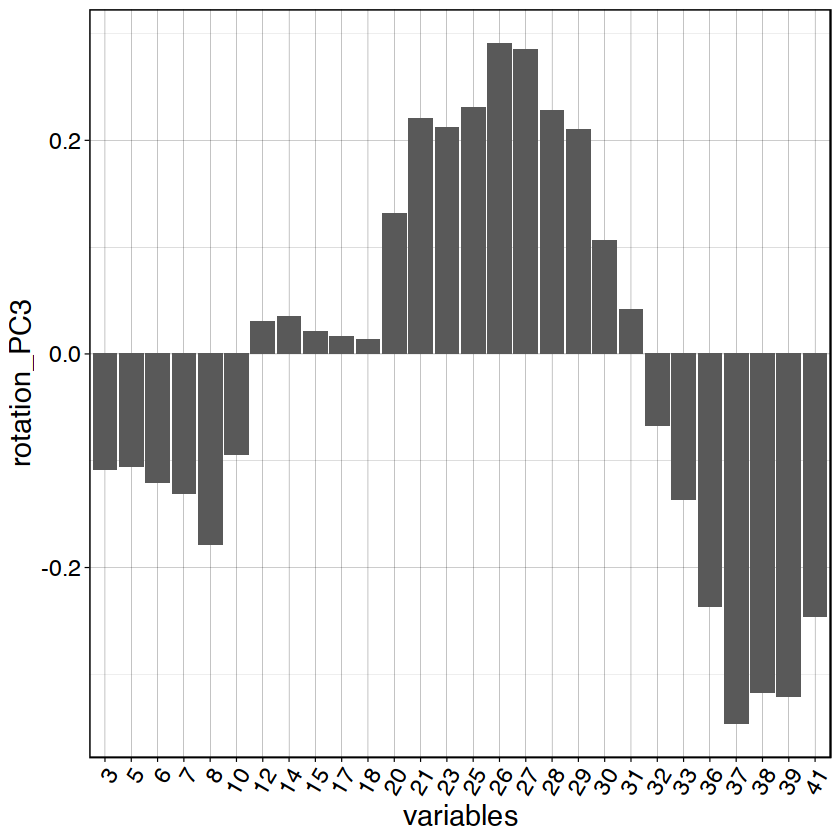

In [10]:
pca.summary <- summary(pca_meth)

df_plot <- data.frame("variables"= rownames(pca.summary$rotation),
                 "rotation_PC1" = pca.summary$rotation[,1],
                 "rotation_PC2" = pca.summary$rotation[,2],
                 "rotation_PC3" = pca.summary$rotation[,3])

#df_plot$variables <- factor(df_plot$variables, levels = c('ns-3', 'L-2', 'ns-2', 'L-1', 'ns-1', 'ARS316', 
#                                         'ns+1', 'ns+2', 'L+2', 'ns+3'))

df_plot$variables <- factor(rownames(pca.summary$rotation), 
                            levels = rownames(pca.summary$rotation))

ggplot(df_plot) + theme_linedraw() +
  geom_col(aes(x= variables, y = rotation_PC1)) + 
  theme(text = element_text(size=17),
        axis.text.x = element_text(angle = 60, hjust=1))

ggplot(df_plot) + theme_linedraw() +
  geom_col(aes(x= variables, y = rotation_PC2)) + 
  theme(text = element_text(size=17),
        axis.text.x = element_text(angle = 60, hjust=1))

ggplot(df_plot) + theme_linedraw() +
  geom_col(aes(x= variables, y = rotation_PC3)) + 
  theme(text = element_text(size=17),
        axis.text.x = element_text(angle = 60, hjust=1))

## Cluster data based on correlation of methylation than on scaled features

In [11]:
cor_mat <- cor(t(scaled_meth),method="spearman")
dissim_mat <- sqrt((1-cor_mat)/2)
dist_mat <- as.dist(dissim_mat)
corr_clust <- hclust(dist_mat, method="ward.D2")

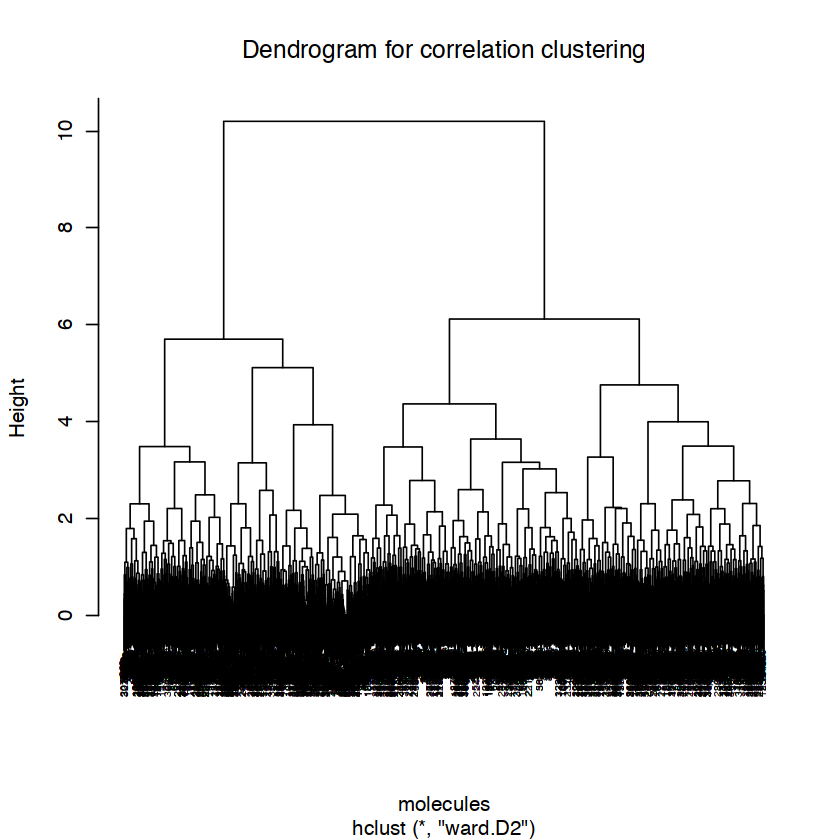

In [12]:
plot(x = corr_clust, cex = 0.5,  labels =  row.names(corr_clust), main = "Dendrogram for correlation clustering",
    xlab = "molecules")

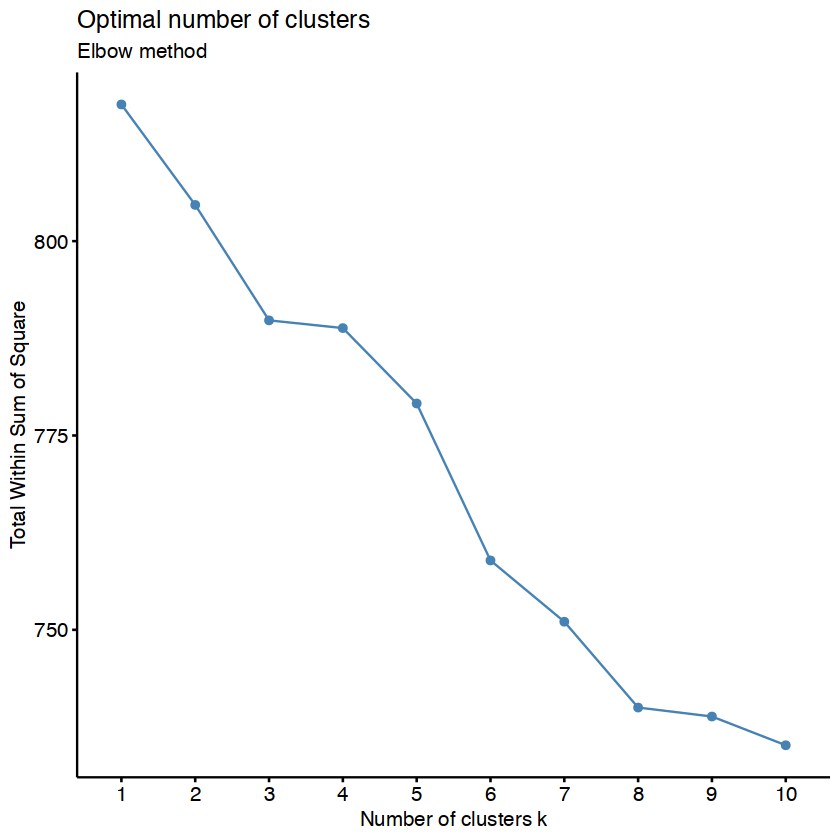

In [24]:
fviz_nbclust(scaled_meth, 
             hcut,
             diss = dist_mat,
             method = "wss") +
  labs(subtitle = "Elbow method")

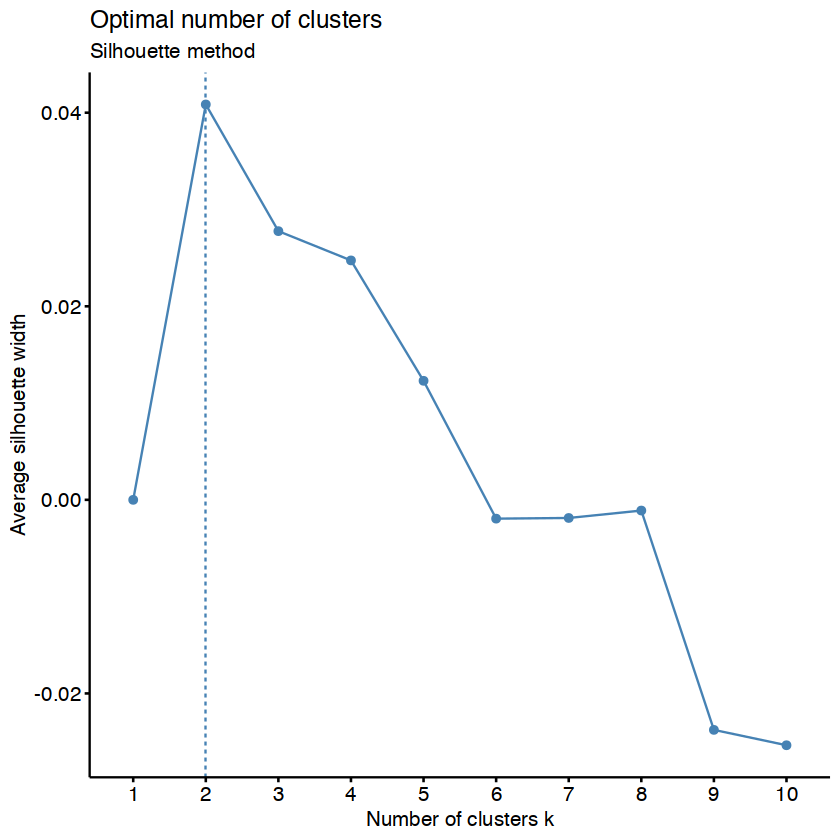

In [26]:
fviz_nbclust(scaled_meth, 
             hcut,
             diss = dist_mat,
             method = "silhouette") +
  labs(subtitle = "Silhouette method")

In [13]:
#cut the dendrogram into 4 clusters
corr_groups <- cutree(corr_clust, k=5)

#find number of observations in each cluster
table(corr_groups)

corr_groups
   1    2    3    4    5 
1133  550  299 1004  491 

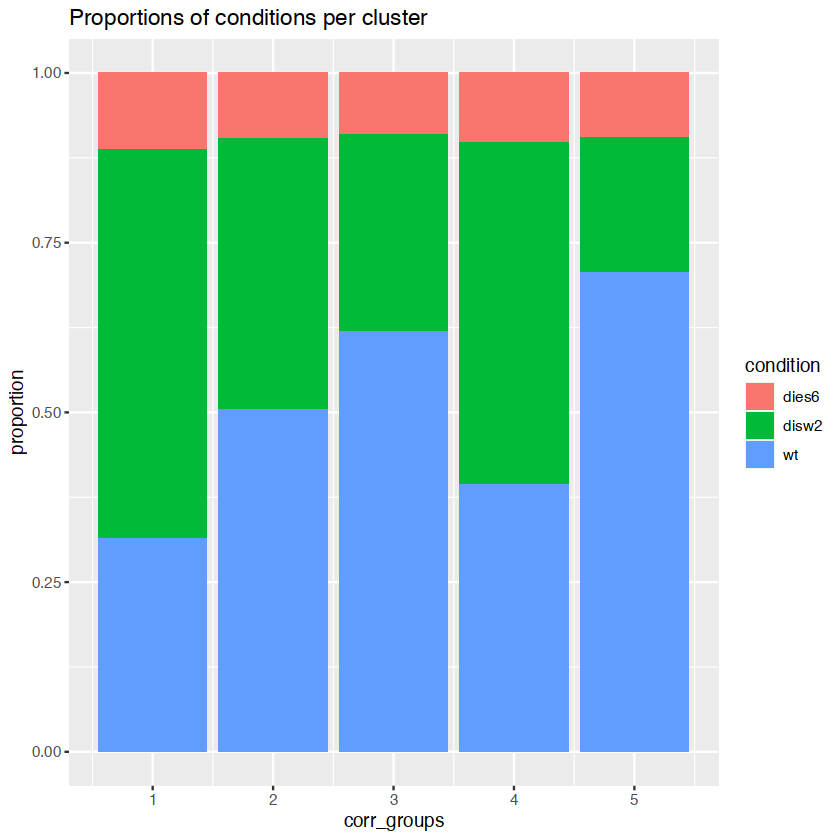

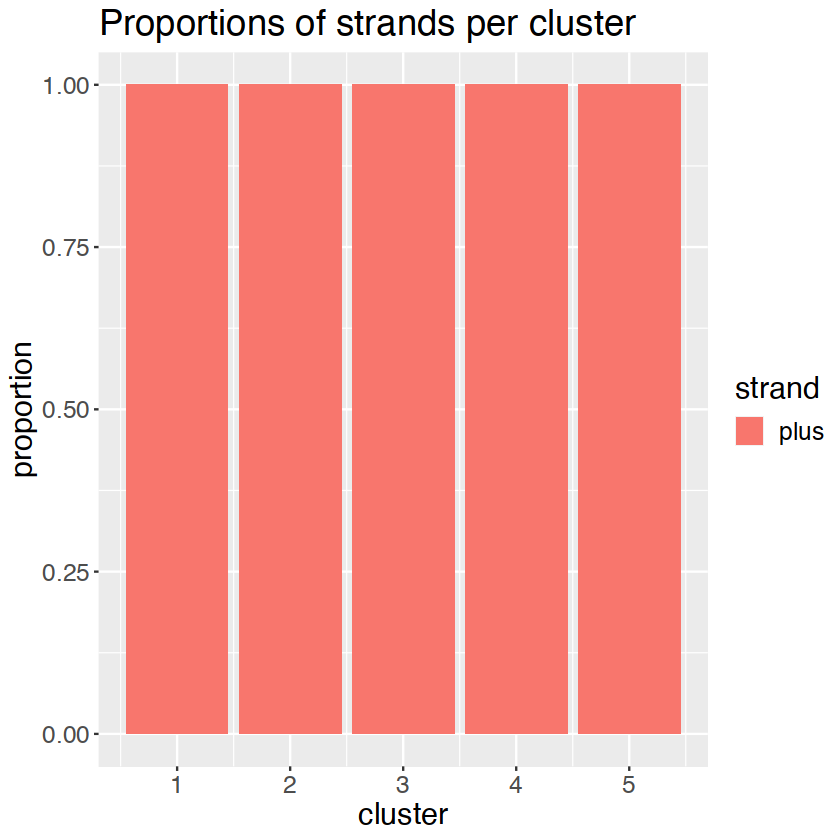

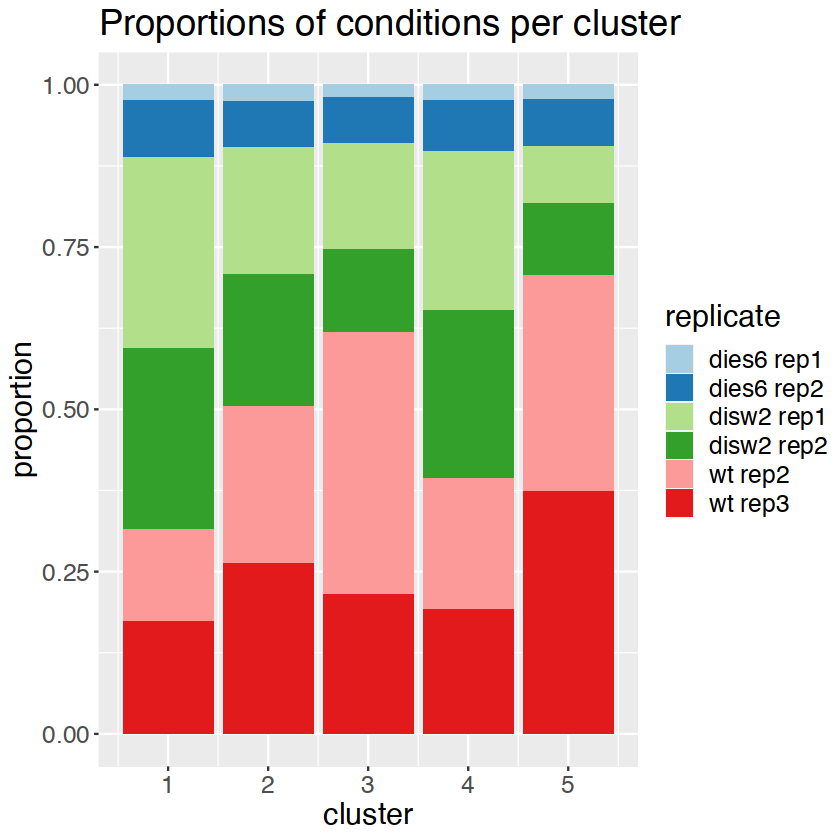

In [14]:
aggr_corr_data <- cbind(methylation_long, corr_groups)

ggplot(data = aggr_corr_data, aes(x = corr_groups, fill = condition)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of conditions per cluster")

ggplot(data = aggr_corr_data, aes(x = corr_groups, fill = strand)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of strands per cluster")  +
  xlab("cluster") + 
  theme(text = element_text(size = 18))
#ggsave(paste(load_dir, "/plots/cluster_strands_ARS316.svg", sep =""), width = 7, height = 5)

ggplot(data = aggr_corr_data, aes(x = corr_groups, fill = replicate)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of conditions per cluster") + 
  scale_fill_brewer(type = "qual", palette = "Paired") +
  xlab("cluster") + 
  theme(text = element_text(size = 18))
#ggsave(paste(load_dir, "/plots/cluster_conditions_ARS316.svg", sep =""), width = 7, height = 5)

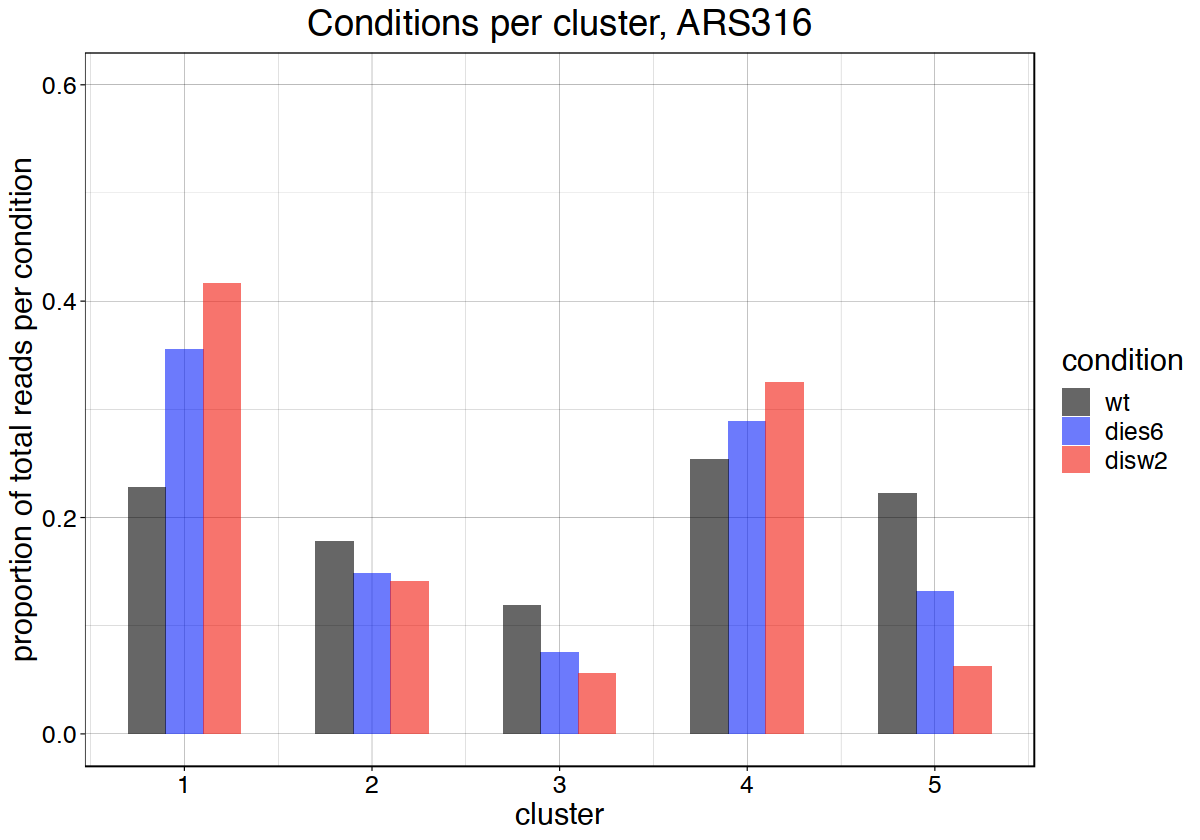

In [15]:

summarise_proportions <- merge(aggr_corr_data %>% group_by(corr_groups) %>% count(condition),
                               aggr_corr_data %>% group_by(condition) %>% summarise(n()))

summarise_proportions$proportion <- summarise_proportions$n/summarise_proportions$`n()`
summarise_proportions$condition <- factor(summarise_proportions$condition, levels = c("wt", "dies6", "disw2"))

options(repr.plot.width=10, repr.plot.height=7)

ggplot(data = summarise_proportions, aes(x = corr_groups, y=proportion, fill = condition)) +
  theme_linedraw() + 
  geom_col(position = "dodge", alpha = 0.6, width = 0.6
          #position = position_dodge(width = 1), width=0.7
          ) +
  scale_fill_manual(values = c("wt" = "black",
                               "dies6" = "#0a22fa", 
                               "disw2" = "#f2180c")) + 
  ylim(0, 0.6) + 
  xlab("cluster") + 
  ylab("proportion of total reads per condition") + 
  ggtitle("Conditions per cluster, ARS316") + 
  theme(text = element_text(size=18),
       plot.title = element_text(hjust = 0.5))
#ggsave(paste(load_dir, "/plots/cluster_occupation_ARS316.svg", sep =""), width = 10, height = 7)

In [16]:
#chi square distance 

chi_dist <- function(vector_a, vector_b){
    if(length(vector_a) == length(vector_b)){
        chi <- 0.5 * sum((vector_a - vector_b)**2/(vector_a + vector_b))
        return(chi)
    }
    else
        print("Error: vectors need to have the same length. Check input values.")
    
}

for(value in unique(summarise_proportions$condition)){
    a = chi_dist(summarise_proportions %>% filter(condition == "wt") %>%arrange(corr_groups) %>% pull(proportion),
                 summarise_proportions %>% filter(condition == value) %>%arrange(corr_groups) %>% pull(proportion)
                 )
    print(paste(value, a))
    }

[1] "dies6 0.0327661630702535"
[1] "disw2 0.0904509921614615"
[1] "wt 0"


In [17]:
aggr_corr_data$total_meth <- rowSums(aggr_corr_data[,5:14])
aggr_corr_data %>% group_by(corr_groups) %>% summarise(mean(total_meth))

corr_groups,mean(total_meth)
<int>,<dbl>
1,12.427157
2,8.892190
3,5.863043
4,15.850204
5,5.320962


`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



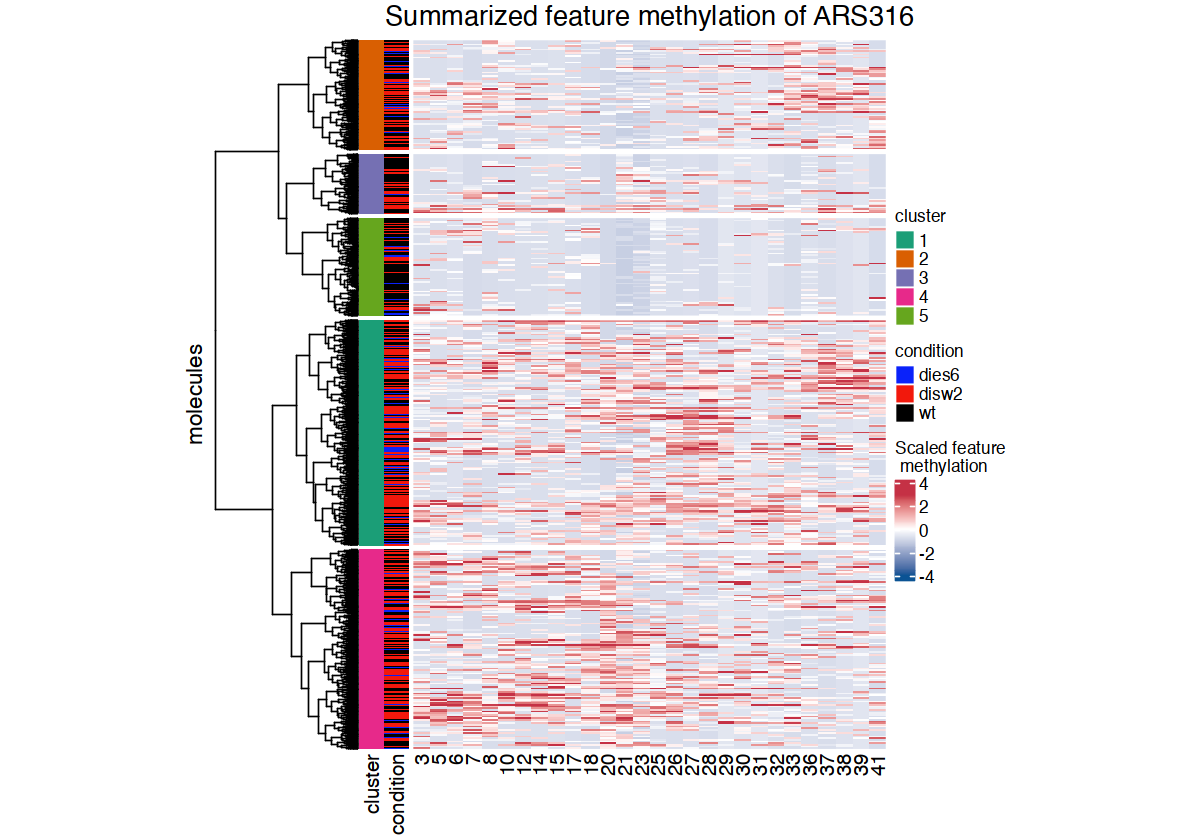

In [18]:
num_cluster <- length(unique(corr_groups))

col_list <- list(cluster = c("1" = '#1B9E77', "2" = '#D95F02', "3" = '#7570B3', "4" = '#E7298A', "5" = '#66A61E', "6" = '#e6ab02'),
                 condition = c("wt" = "black", "dies6" = "#0a22fa", "disw2" = "#f2180c"))
#Heatmap annotation
ha <- rowAnnotation(
    cluster = corr_groups, 
    condition = aggr_corr_data$condition, #insert replicate ?
    col = col_list 
)


color_func <- colorRamp2(c(-4,0,3), c("#0b5394", "white", "#c53145"))

Heatmap(scaled_meth, name = "Scaled feature \n methylation", #title of legend
       row_title = "molecules",
       show_row_names = FALSE,
        row_split = num_cluster,
        cluster_columns = FALSE,
        cluster_rows = as.dendrogram(corr_clust), row_dend_width = unit(3, "cm"),
        width = unit(10, "cm"), height = unit(15, "cm"),
        col = color_func, 
        column_title = "Summarized feature methylation of ARS316", column_title_gp = gpar(fontsize = 16, fontface = "bold"),
        left_annotation = ha
       )

### In order to have the clusters on the left of the heatmap in a consistent order with their numbering, assign a new variable clusters_new with a custom order of the clusters in the heatmap. (Alternative: reorder the hcust object or the dendrogram)

In [22]:
cluster_new <- factor(corr_groups)

In [23]:
levels(cluster_new) #cluster are in the ascending order. Now assign each cluster the position it should have in the new plot.

[1] "1" "2" "3" "4" "5"

In [24]:
levels(cluster_new) <- c(4,1,2,5,3) 

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



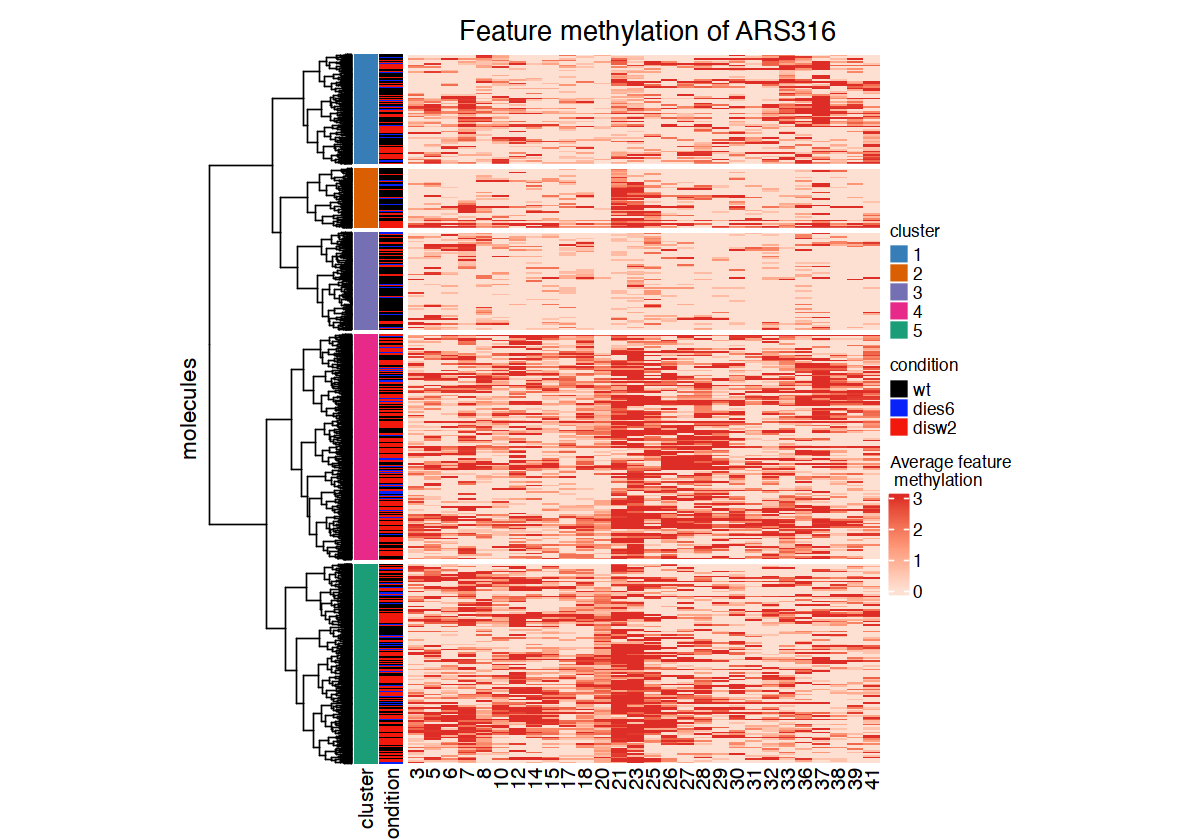

In [25]:
##Heatmap annotation

col_list <- list(cluster = c("1" = '#377eb8', "2" = '#D95F02', "3" = '#7570B3', "4" = '#E7298A', "5" = '#1B9E77', "6" = '#e6ab02', "7" = '#a6761d'),
                 condition = c("wt" = "black", "dies6" = "#0a22fa", "disw2" = "#f2180c"))

ha <- rowAnnotation(
    cluster = factor(cluster_new, levels = c(1,2,3,4,5)), 
    condition = factor(aggr_corr_data$condition, levels = c("wt", "dies6", "disw2")),
    col = col_list 
)

color_func <- colorRamp2(c(0,1.5,3), brewer.pal(3, "Reds"))

#pdf(paste(load_dir, "/plots/heatmap_5cluster_ARS316_revision.pdf", sep=""), width= 10, height=15)
Heatmap(as.matrix(aggr_corr_data[,5:(ncol(aggr_corr_data)-2)]), name = "Average feature \n methylation", #title of legend
       row_title = "molecules",
       show_row_names = FALSE,
        cluster_columns = FALSE,
        row_split = num_cluster, cluster_rows = as.dendrogram(corr_clust), row_dend_width = unit(3, "cm"),
        
        width = unit(10, "cm"), height = unit(15, "cm"),
        col = color_func, 
        column_title = " \n Feature methylation of ARS316", 
        column_title_gp = gpar(fontsize = 16, fontface = "bold"),
        left_annotation = ha
       )
#dev.off()

## Plot this heatmap more simplified by displaying the average methylation by feature and cluster

In [26]:
aggr_corr_data$corr_groups <- cluster_new

In [27]:
simple_heatmap_data <- aggr_corr_data[,5:(ncol(aggr_corr_data)-1)] %>% melt(id.vars="corr_groups", 
                                                                            variable.name= "feature") %>%
                       group_by(corr_groups, feature) %>% summarise(avg = round(mean(value), digits =2))

`summarise()` has grouped output by 'corr_groups'. You can override using the `.groups` argument.


In [28]:
simple_heatmap_data$corr_groups <- factor(simple_heatmap_data$corr_groups, levels = c(1,2,3,4,5))

In [29]:
quantile(simple_heatmap_data$avg, probs = c(0, 0.1, 0.5, 0.75, 0.90, 1))

0%    10%    50%    75%    90%   100% 
0.0500 0.2980 0.9650 1.3725 2.1660 4.9300

In [30]:
simple_heatmap_plotdata <- dcast(simple_heatmap_data, corr_groups ~feature, value.var = "avg")

In [31]:
add_columns_df = as.data.frame(matrix(1:34, ncol = 34))
colnames(add_columns_df) = seq(34)

# add the columns with non-significant methylation difference between wt and mutants, fill with NAs
full_features_df = merge(simple_heatmap_plotdata, add_columns_df, all =TRUE)

full_features_df <- full_features_df[is.na(full_features_df[,ncol(full_features_df)]),] # remove the row of the dummy dataframe

full_features_df <- full_features_df[order(as.numeric(full_features_df$corr_groups)), ] #reorder rows according to cluster info
full_features_df <- subset(full_features_df, select = -corr_groups) # remove column with cluster info
full_features_df <- full_features_df[,order(as.numeric(colnames(full_features_df)))] #reorder columns

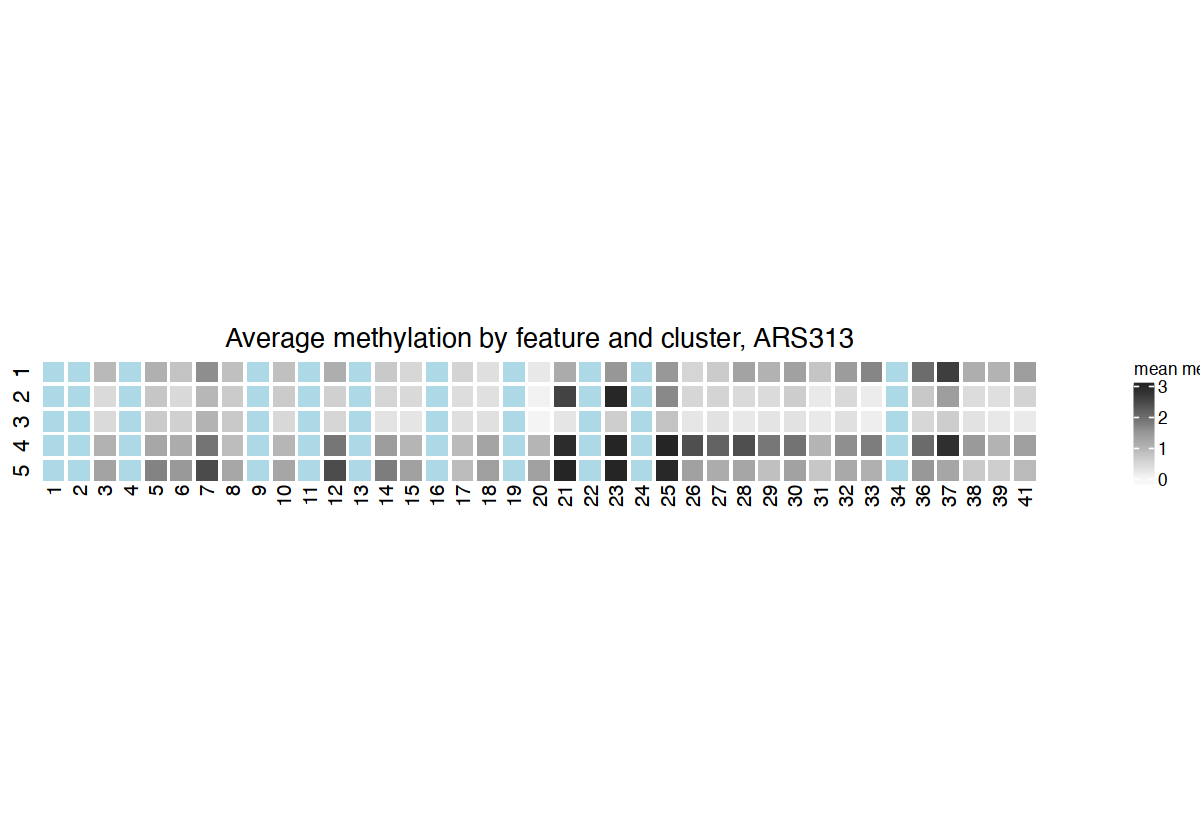

In [32]:
color_func <- colorRamp2(c(0, 1.5, 3), c("#f7f7f7", "#969696", "#252525"))

#pdf(paste(load_dir, "/plots/methylation_schematic_ARS316_revision.pdf", sep=""), width= 21, height=2.5)
Heatmap(as.matrix(full_features_df),
        name = "mean methylation", #title of legend
        show_row_names = FALSE,
        row_order = 1:5, 
        cluster_columns = FALSE,
        row_split = seq(5),
        column_split = seq(ncol(full_features_df)),
        
        width = unit(21, "cm"), height = unit(2.5, "cm"),
        col = color_func, 
        
        na_col = "lightblue",
        
        column_title = "Average methylation by feature and cluster, ARS313", 
        column_title_gp = gpar(fontsize = 16)
       )
#dev.off()

### Flip the plot for the Figure panel 7f by 90 degree and make the cluster order match the heatmap:

In [33]:
summarise_proportions$corr_groups <- factor(summarise_proportions$corr_groups)

In [34]:
levels(summarise_proportions$corr_groups)

[1] "1" "2" "3" "4" "5"

In [35]:
summarise_proportions$cluster_new <- factor(summarise_proportions$corr_groups)
levels(summarise_proportions$cluster_new) <- c(4,1,2,5,3) #rename the clusters so they are in the same order than the heatmap
summarise_proportions$cluster_new <- factor(summarise_proportions$cluster_new, 
                                             levels = rev(c('1','2', '3', '4', '5'))
                                             )
#reverse the order of the factor levels of condition:
summarise_proportions$condition <- factor(summarise_proportions$condition, 
                                                  levels = c("disw2", "dies6", "wt"))

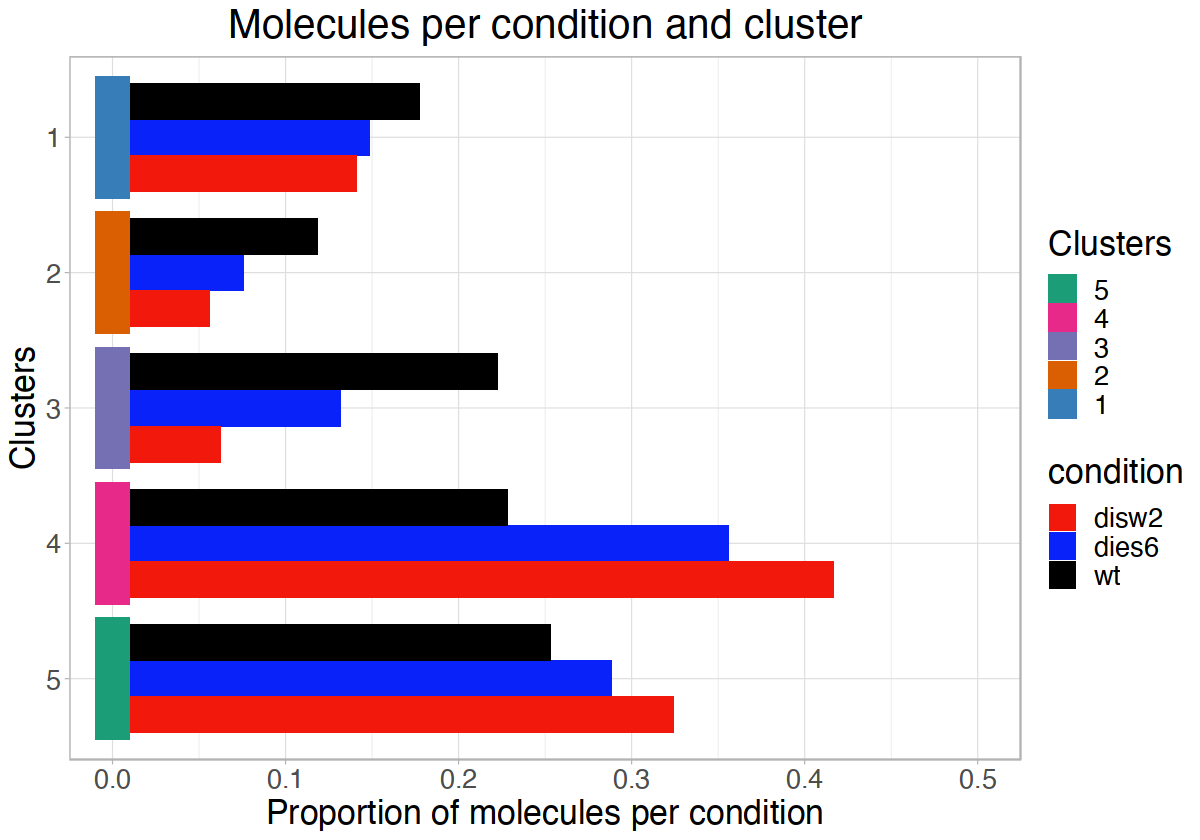

In [36]:
ggplot(data = summarise_proportions, aes(x = cluster_new, y=proportion, fill = condition)) +
  theme_light() + 
  geom_col(position = "dodge", #alpha = 0.6, 
           width = 0.8
          ) +
  scale_fill_manual(values = c("wt" = "black",
                               "dies6" = "#0a22fa", 
                               "disw2" = "#f2180c")) +
  new_scale_fill() +
  geom_tile(data = dplyr::distinct(summarise_proportions, cluster_new), 
            aes(y = 0, x = cluster_new, fill = cluster_new), 
            height = 0.02, width = 0.9, 
            inherit.aes = FALSE) + 
  scale_fill_manual(values = c('1' ='#377eb8',
                               '2'='#D95F02', 
                               '3'='#7570B3', 
                               '4'='#E7298A', 
                               '5'='#1B9E77'),
                    name = "Clusters",
                   ) +
  xlab("Clusters") + 
  ylab("Proportion of molecules per condition") +
  
  ggtitle("Molecules per condition and cluster") +
  theme(text = element_text(size=20),
       plot.title = element_text(hjust = 0.5)) +
  coord_flip(ylim=c(0, 0.5))
#ggsave(paste(load_dir, "/plots/cluster_occupation_ARS316_revision.svg", sep =""), width = 7, height = 10)

## Replot replicates over cluster

In [37]:
aggr_corr_data$corr_groups <- factor(aggr_corr_data$corr_groups, levels = seq(5))

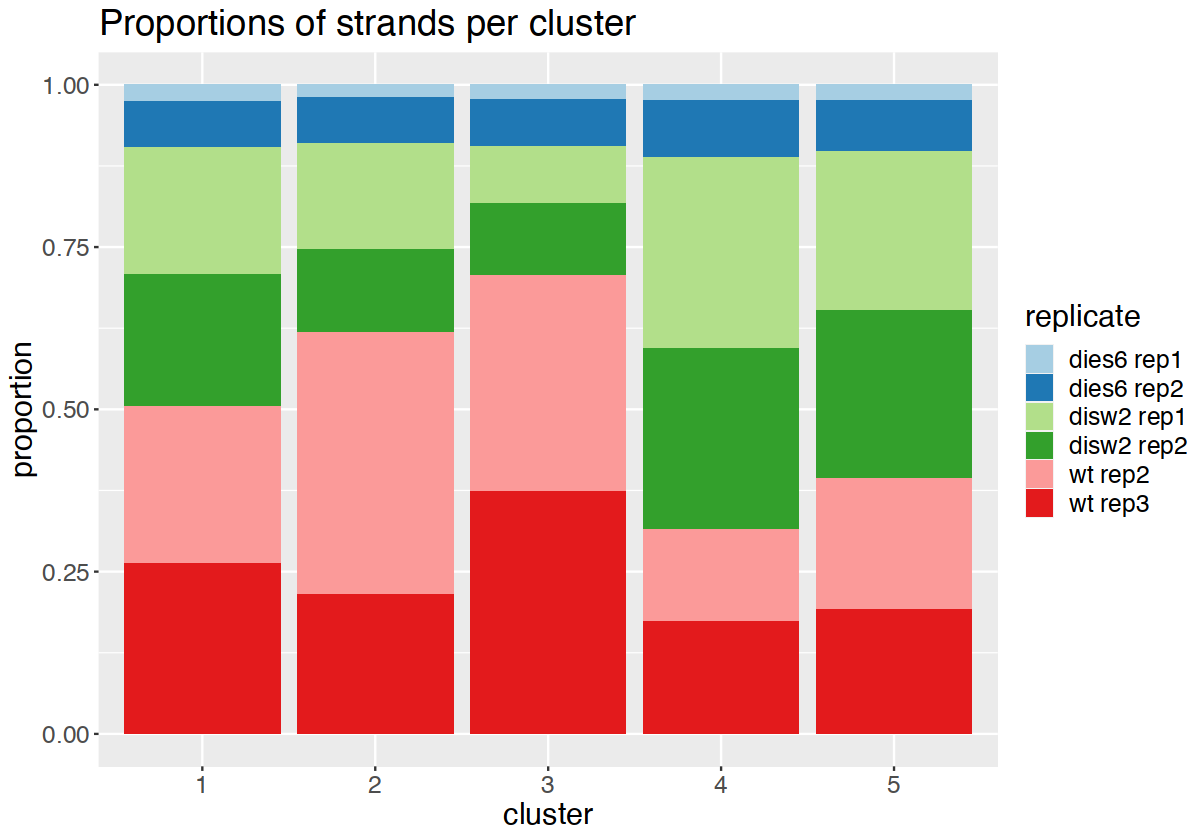

In [38]:
ggplot(data = aggr_corr_data, aes(x = corr_groups, fill = replicate)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of strands per cluster")  + 
  xlab("cluster") + 
  scale_fill_brewer(type = "qual", palette = "Paired") + 
  theme(text = element_text(size = 18))
  #ggsave(paste(load_dir, "/plots/cluster_occupation_ARS316_revision_replicates.svg", sep =""), width = 7, height = 5)

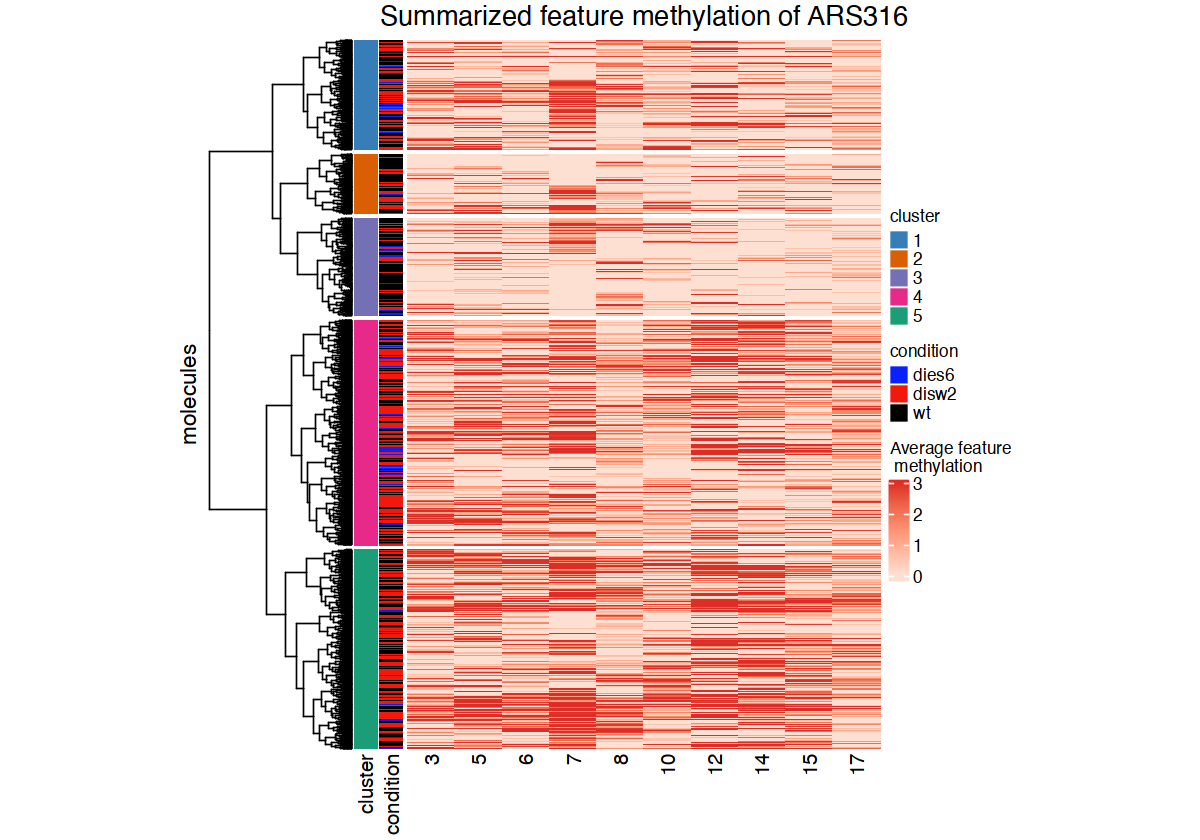

In [39]:
num_cluster <- length(unique(corr_groups))

#Heatmap annotation
ha <- rowAnnotation(
    cluster = aggr_corr_data$corr_groups, 
    condition = aggr_corr_data$condition,
    col = col_list 
)


color_func <- colorRamp2(c(0,1.5,3), brewer.pal(3, "Reds"))#c("#0b5394", "white", "#c53145"))
#aggr_corr_data %>% arrange(groups, condition)%>% select(c(5:14))

#pdf(paste(load_dir, "/plots/heatmap_5cluster_ARS316.pdf", sep=""), width= 10, height=15)
Heatmap(as.matrix(aggr_corr_data[,5:14]), name = "Average feature \n methylation", #title of legend
       row_title = "molecules",
       show_row_names = FALSE,
       row_split = num_cluster,
        cluster_columns = FALSE,
        cluster_rows = as.dendrogram(corr_clust), row_dend_width = unit(3, "cm"),
        #row_order = 
        width = unit(10, "cm"), height = unit(15, "cm"),
        col = color_func, 
        column_title = "Summarized feature methylation of ARS316", column_title_gp = gpar(fontsize = 16, fontface = "bold"),
        left_annotation = ha
       )
#dev.off()

In [40]:
aggr_corr_data$total_methylation <- rowSums(aggr_corr_data[,5:14])
plot_sorted_rows <- aggr_corr_data %>% arrange(corr_groups, condition, total_methylation)

aggr_corr_data <- aggr_corr_data[,-ncol (aggr_corr_data)]

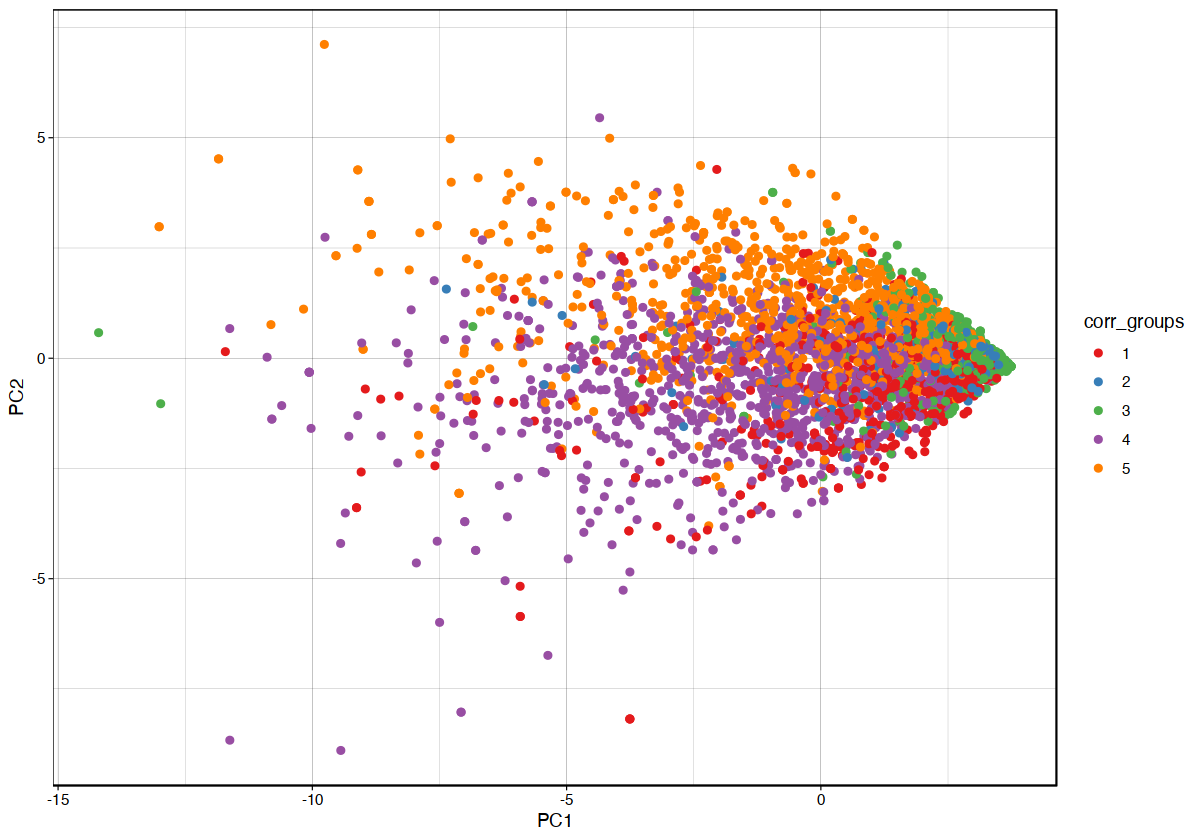

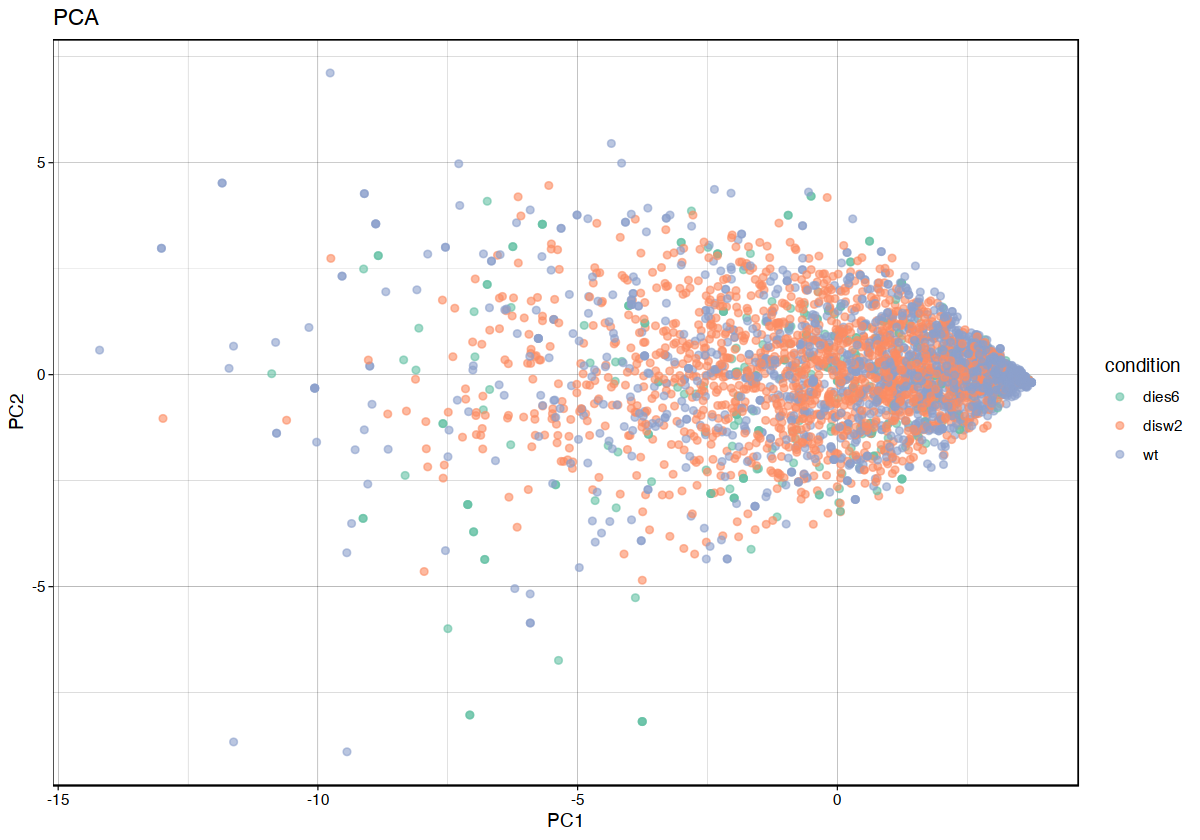

In [42]:
aggr_corr_data$corr_groups <- as.factor(aggr_corr_data$corr_groups)

plot_pc_aggr_data <- cbind(pca_meth$x[,1:2], aggr_corr_data)

ggplot(plot_pc_aggr_data) + 
theme_linedraw() + 
geom_point(aes(x = PC1, y = PC2, color = corr_groups)) +
  scale_color_brewer(type = "qual", palette = "Set1")

ggplot(plot_pc_aggr_data, aes(x = PC1, y = PC2, color= condition)) + 
  theme_linedraw() + 
  geom_point(alpha=0.6) +
  scale_color_brewer(type = "qual", palette = "Set2") +
  labs(title = "PCA")  